In [5]:
%matplotlib inline

In [6]:
from sklearn import datasets, svm
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target
svc = svm.SVC(C=1, kernel='linear')
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.97999999999999998

In [7]:
import numpy as np
# split array by 3 // about 599
# shape : (3, 599, 64)
X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)

# KFold cross-validation
scores = list()
for k in range(3):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    # by 599
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_train = np.concatenate(y_train)
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
print(scores)

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]


# Cross-validation generators

### KFold

In [8]:
from sklearn.model_selection import KFold, cross_val_score
X = ["a", "a", "b", "c", "c", "c"]
k_fold = KFold(n_splits=3)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5] | test: [0 1]
Train: [0 1 4 5] | test: [2 3]
Train: [0 1 2 3] | test: [4 5]


In [9]:
kfold = KFold(n_splits=3)
[svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test])
         for train, test in k_fold.split(X_digits)]

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]

By default the estimator’s score method is used to compute the individual scores.
n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.

In [10]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold, n_jobs=-1)

array([ 0.93489149,  0.95659432,  0.93989983])

In [11]:
# The scoring argument can be provided to specify an alternative scoring method.
cross_val_score(svc, X_digits, y_digits, cv=k_fold,
                scoring='precision_macro')

array([ 0.93969761,  0.95911415,  0.94041254])

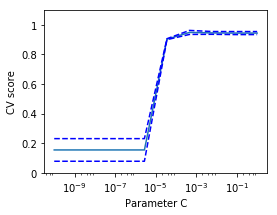

In [12]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import datasets, svm

digits = datasets.load_digits()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))


# Do the plotting
import matplotlib.pyplot as plt

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

# Grid-search and cross-validated estimators

In [13]:
from sklearn.model_selection import GridSearchCV, cross_val_score
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs),
                   n_jobs=-1)
clf.fit(X_digits[:1000], y_digits[:1000])        

print(clf.best_score_)                                  

print(clf.best_estimator_.C)                            


# Prediction performance on test set is not as good as on train set
clf.score(X_digits[1000:], y_digits[1000:])

0.925
0.00774263682681


0.94353826850690092

In [14]:
# uses a 3-fold cross-validation by default
# if it detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
cross_val_score(clf, X_digits, y_digits)

array([ 0.93853821,  0.96327212,  0.94463087])

In [19]:
from sklearn import linear_model, datasets
# CV : cross validation
lasso = linear_model.LassoCV()
diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target
lasso.fit(X_diabetes, y_diabetes)


# The estimator chose automatically its lambda:
lasso.alpha_

0.012291895087486161

[ 0.10075479  0.10073614  0.10071154  0.10067903  0.10063605  0.10057921
  0.10050419  0.10040475  0.10027332  0.10009887  0.09986768  0.09955988
  0.09914979  0.09860059  0.09785529  0.09726523  0.09810478  0.09895163
  0.09903432  0.09890238  0.09848222  0.09766696  0.09589727  0.09365584
  0.09080343  0.08771014  0.08267486  0.07774865  0.07339416  0.07060905]


(0.0001, 0.31622776601683794)

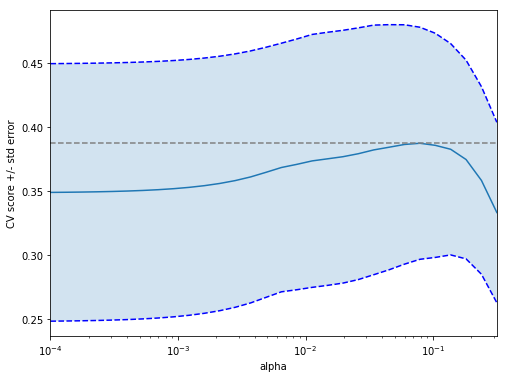

In [27]:
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

diabetes = datasets.load_diabetes()

X = diabetes.data[:150]
y = diabetes.target[:150]

lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, X, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    
scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])